# 1. Import Dependencies

In [1]:
import os
import cv2 as cv
import gdown
import imageio
import numpy as np
from typing import List
import tensorflow as tf
import matplotlib.pyplot as plt

# 2. Loading Data

In [3]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall(output)

* Loading Videos Function

In [2]:
def load_video(path: str) -> List[float]:
    cap = cv.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [3]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'!?123456789 "]

* tokenizing characters to numbers & viceversa

In [4]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    oov_token="",
    invert=True
)
print(char_to_num(['a', 'k', 'l', 'x']))
print(num_to_char([14, 2, 5, 20]))
print(char_to_num(['$']))

tf.Tensor([ 1 11 12 24], shape=(4,), dtype=int64)
tf.Tensor([b'n' b'b' b'e' b't'], shape=(4,), dtype=string)
tf.Tensor([0], shape=(1,), dtype=int64)


* Loading Alignments (Annotations)

In [5]:
def load_alignment(path: str) -> List[float]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, "UTF-8"), (-1)))[1:]

* Loading Data Function (both 2 previous functions)

In [6]:
def load_data(path):
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignment(alignment_path)
    return frames, alignments

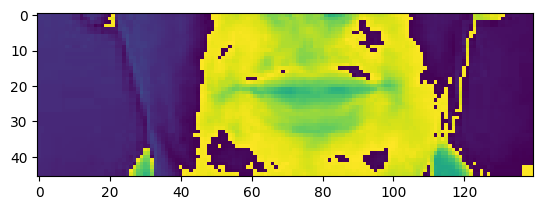

In [7]:
test_path = 'data\\s1\\bbaf2n.mpg'
test_path = tf.convert_to_tensor(test_path)
frames, alignments = load_data(test_path)
plt.imshow(frames[40])

In [8]:
tf.strings.reduce_join([bytes.decode(x, 'utf-8') for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

* Mappable Function

In [7]:
def mappable(path: str) -> List[float]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 3. Creating Data Pipeline

In [8]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)
len(data)

500

* Split to train & test

In [9]:
train = data.take(450)
test = data.skip(450)
len(test)

50

In [10]:
test_item = data.as_numpy_iterator().next()
# frames = test_item[0][0].T[0].T * 50
imageio.mimwrite('./animation.gif', test_item[0][0])

Lossy conversion from float32 to uint8. Range [0.0, 10.288030624389648]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.288030624389648]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.288030624389648]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.288030624389648]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.288030624389648]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.288030624389648]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.288030624389648]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to u

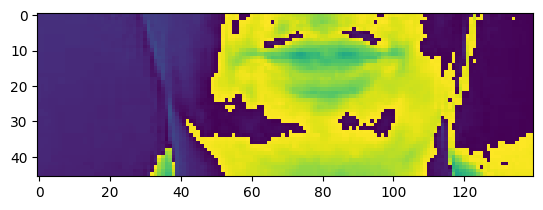

In [14]:
plt.imshow(test_item[0][0][30])

In [15]:
tf.strings.reduce_join([num_to_char(word) for word in test_item[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay green in f two please'>

# 4. Design Deep Neural Network

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPooling3D, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [11]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same', activation='relu'))
model.add(MaxPooling3D((1, 2, 2)))
model.add(Conv3D(256, 3, padding='same', activation='relu'))
model.add(MaxPooling3D((1, 2, 2)))
model.add(Conv3D(75, 3, padding='same', activation='relu'))
model.add(MaxPooling3D((1, 2, 2)))
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 75, 11, 35, 75)    518475    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 75, 5, 17, 75)    0

# 5. Setup Training Options & Train

In [12]:
def schedular(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [13]:
def ctc_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
    label_len = tf.cast(tf.shape(y_true)[1], dtype='int64')
    input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64')

    input_len = input_len * tf.ones(shape=(batch_len, 1), dtype='int64')
    label_len = label_len * tf.ones(shape=(batch_len, 1), dtype='int64')
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_len, label_len)
    return loss

In [14]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset):
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None):
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()

        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~' * 100)

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=ctc_loss)

In [17]:
file_path = 'models/checkpoint-{loss:.3f}.model'
check_point = ModelCheckpoint(file_path, monitor='loss', save_best_only=True)
schedule_callback = LearningRateScheduler(schedular)
example = ProduceExample(data)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[check_point, schedule_callback, example])

In [16]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=ee2954f2-72ec-49a9-be35-16707b2a90f5
To: c:\Users\Basel\PycharmProjects\TensorFlow\venv\projects\Lip-Reading-Model\checkpoints.zip
100%|██████████| 94.5M/94.5M [18:31<00:00, 85.0kB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [16]:
model.load_weights('models/checkpoint')